In [ ]:
import pandas as pd
import numpy as np
import pickle
import sys
from sentence_transformers import SentenceTransformer
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras import Sequential, regularizers 

from keras.layers import Embedding, LSTM, Dense
from keras import losses
from keras.layers import Dense
from keras.layers import Flatten, InputLayer

import time
from keras.callbacks import EarlyStopping, ModelCheckpoint
import torch
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn import metrics
import plotly.express as px
from transformers import AutoTokenizer, AutoModel


In [ ]:
pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.4 MB/s 
     |████████████████████████████████| 5.8 MB 48.7 MB/s 
     |████████████████████████████████| 1.3 MB 30.2 MB/s 
     |████████████████████████████████| 182 kB 48.5 MB/s 
     |████████████████████████████████| 7.6 MB 44.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=ff8c74cc8d93e34d9c6a83253c46a5c0dbf7a3720fdb80b21db79390ad31edcf
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_df = "/content/drive/MyDrive/fake_bert/politifact_global_feature.pkl"

In [ ]:
df = pickle.load(open(path_df, "rb"))

In [ ]:
df.head()

In [ ]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = tensor.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = tensor.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

In [ ]:
path_to_arr = "/content/drive/MyDrive/fake_bert/politifact_micro_macro_struct_temp_linguistic_textual_graphical_sample_features.pkl"
sample_feature_array = pickle.load(open(path_to_arr, "rb"))

In [ ]:
x_train, x_test, y_train, y_test, f_train, f_test = train_test_split(df['comp_text'], df['target'], df.iloc[:, 10:70], test_size= .20, random_state= 111, stratify= df['target'] )

In [ ]:
def cls_pooling(model_output, attention_mask):
    return model_output[0][:,0]

def get_embeds(embedd):
  embed_tok = tokenizer(embedd.tolist(), padding=True, truncation=True, max_length=512, return_tensors='pt')

  with torch.no_grad():
    model_output = model(**embed_tok)

#Perform pooling. In this case, mean pooling
  # sentence_embeddings = mean_pooling(model_output, embed_tok['attention_mask'])
  # mean_pooled = model_output.sum(axis=1) / attention_mask.sum(axis=-1).unsqueeze(-1)
  sentence_embeddings = cls_pooling(model_output, embed_tok['attention_mask'])
  # tf.convert_to_tensor(sentence_embeddings, dtype='float32')
  return tf.convert_to_tensor(sentence_embeddings, dtype='float32')

In [ ]:
embed_train = get_embeds(x_train)
embed_test = get_embeds(x_test)

In [ ]:
scaler = preprocessing.MinMaxScaler()
f_train_transform = scaler.fit_transform(f_train)
f_test_transform = scaler.fit_transform(f_test)

In [ ]:
merged_train_arr = [embed_train, f_train_transform]
merged_test_arr = [embed_test, f_test_transform]

In [ ]:
from xgboost import XGBClassifier

In [ ]:
gs_xgb = XGBClassifier(
                eta=0.3,
                n_estimators=500,
                gamma=[0, 0.5, 1],
                max_depth=4,
                min_child_weight=1,
                colsample_bytree=1,
                colsample_bylevel=1,
                subsample=1,
                seed=233
            )
param_grid = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                           'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                          {'kernel': ['sigmoid'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                           'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                          {'kernel': ['linear'], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}
                          ]
grid = GridSearchCV(gs_xgb, param_grid, refit=True, cv=cv, verbose=3, scoring='roc_auc')
            

NameError: ignored

In [ ]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
start = time.time()
berthist = bertLayerModel.fit(merged_train_arr,y_train,validation_data=(merged_val_arr, y_val),
                    epochs= epochs,batch_size= batch_size, verbose=1, callbacks=[earlyStopping, mcp_save])
print(time.time()-start)

Epoch 1/100
4/4 [==============================] - 1s 79ms/step - loss: 0.6646 - accuracy: 0.5966 - val_loss: 0.5878 - val_accuracy: 0.7407
Epoch 2/100
4/4 [==============================] - 0s 18ms/step - loss: 0.5863 - accuracy: 0.7773 - val_loss: 0.5100 - val_accuracy: 0.7407
Epoch 3/100
4/4 [==============================] - 0s 14ms/step - loss: 0.5125 - accuracy: 0.8697 - val_loss: 0.4366 - val_accuracy: 0.8889
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 0.4472 - accuracy: 0.8824 - val_loss: 0.3607 - val_accuracy: 0.8889
Epoch 5/100
4/4 [==============================] - 0s 14ms/step - loss: 0.3853 - accuracy: 0.8908 - val_loss: 0.3017 - val_accuracy: 0.8889
Epoch 6/100
4/4 [==============================] - 0s 15ms/step - loss: 0.3371 - accuracy: 0.8866 - val_loss: 0.2600 - val_accuracy: 0.8889
Epoch 7/100
4/4 [==============================] - 0s 14ms/step - loss: 0.2933 - accuracy: 0.9160 - val_loss: 0.2232 - val_accuracy: 0.8889
Epoch 8/100
4/4 [===

In [ ]:
file_name = "/content/drive/MyDrive/fake_bert/sbert_model_finetune"

In [ ]:
torch.save(model, file_name)

In [ ]:
bertLayerModel_pred = bertLayerModel.predict(merged_test_arr)
bertLayerModel_y = np.argmax(bertLayerModel_pred, axis = 1)
bertLayerModel_y

2/2 [==============================] - 0s 9ms/step


array([0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1])

In [ ]:
bertLayerModel_pred

array([[9.9574393e-01, 4.2560054e-03],
       [6.9568783e-01, 3.0431223e-01],
       [7.0160598e-01, 2.9839396e-01],
       [2.4840649e-04, 9.9975169e-01],
       [2.7568215e-01, 7.2431785e-01],
       [9.9588555e-01, 4.1144071e-03],
       [2.7165122e-04, 9.9972844e-01],
       [9.8799753e-01, 1.2002448e-02],
       [3.6879689e-03, 9.9631214e-01],
       [9.8130691e-01, 1.8693008e-02],
       [7.6417837e-06, 9.9999231e-01],
       [9.9890655e-01, 1.0934402e-03],
       [9.7050166e-01, 2.9498266e-02],
       [9.7522992e-05, 9.9990243e-01],
       [1.2746736e-02, 9.8725325e-01],
       [9.8651612e-01, 1.3483876e-02],
       [2.6936091e-02, 9.7306389e-01],
       [4.5154450e-04, 9.9954838e-01],
       [9.9957651e-01, 4.2348407e-04],
       [2.3772632e-01, 7.6227367e-01],
       [1.9127825e-01, 8.0872178e-01],
       [3.0053411e-06, 9.9999696e-01],
       [7.3132575e-01, 2.6867422e-01],
       [6.2005341e-01, 3.7994656e-01],
       [9.9152362e-01, 8.4763533e-03],
       [2.2770559e-02, 9.

In [ ]:
print('Accuracy:', accuracy_score(bertLayerModel_y, y_test))
print('F1 score:', f1_score(y_test, bertLayerModel_y))
print('Recall:', recall_score(y_test, bertLayerModel_y))
print('Precision:', precision_score(y_test, bertLayerModel_y))
print('ROC_AUC Score:', roc_auc_score(y_test, bertLayerModel_y))
print(classification_report(y_test, bertLayerModel_y))

Accuracy: 0.8085106382978723
F1 score: 0.8085106382978724
Recall: 0.8260869565217391
Precision: 0.7916666666666666
ROC_AUC Score: 0.8088768115942029
              precision    recall  f1-score   support

           0       0.83      0.79      0.81        24
           1       0.79      0.83      0.81        23

    accuracy                           0.81        47
   macro avg       0.81      0.81      0.81        47
weighted avg       0.81      0.81      0.81        47



In [ ]:
weighted_results = bertLayerModel.evaluate(tf.convert_to_tensor(embed_test, dtype='float32'), y_test,
                                           batch_size=64, verbose=0)
for name, value in zip(bertLayerModel.metrics_names, weighted_results):
  print(name, ': ', value)
print()

ValueError: ignored

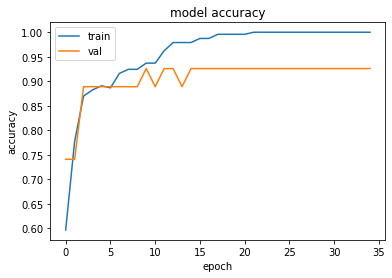

In [ ]:
from matplotlib import pyplot as plt

plt.plot(berthist.history['accuracy'])
plt.plot(berthist.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from matplotlib import pyplot as plt

plt.plot(berthist.history['loss'])
plt.plot(berthist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
precision, recall, thresholds = precision_recall_curve(bertLayerModel_y, y_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, bertLayerModel_y, pos_label=1)

fig = px.area(
    x=recall, y=precision,
    title=f'Precision-Recall Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='Recall', y='Precision'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()